<a href="https://colab.research.google.com/github/q4quang/AIO-2024/blob/feature/auto_mpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download Dataset

In [1]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 27.2MB/s]


In [2]:
!mkdir data
!mv Auto_MPG_data.csv data/Auto_MPG_data.csv

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Read Dataset

In [6]:
dataset_path = 'data/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


#### Preprocess

In [7]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [8]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(273, 9)
(79, 9)
(40, 9)


In [9]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Create PyTorch DataLoader

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Build MLP Network

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output(x)
        return x.squeeze(1)

In [13]:
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

In [14]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
def r_squared(y, y_pred):
    y = torch.Tensor(y).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

### Train

In [16]:
epochs = 100
train_losses, val_losses, train_r2, val_r2 = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.extend(y_pred.tolist())
        train_target.extend(y_batch.tolist())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict).item())

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.extend(y_pred.tolist())
            val_target.extend(y_batch.tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict).item())

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/100:	train_loss: 282.769	val_loss: 88.672
Epoch 2/100:	train_loss: 137.669	val_loss: 72.346
Epoch 3/100:	train_loss: 71.007	val_loss: 19.143
Epoch 4/100:	train_loss: 25.083	val_loss: 196.176
Epoch 5/100:	train_loss: 96.139	val_loss: 20.444
Epoch 6/100:	train_loss: 17.765	val_loss: 9.444
Epoch 7/100:	train_loss: 18.486	val_loss: 14.535
Epoch 8/100:	train_loss: 37.859	val_loss: 37.427
Epoch 9/100:	train_loss: 17.133	val_loss: 38.134
Epoch 10/100:	train_loss: 22.991	val_loss: 41.183
Epoch 11/100:	train_loss: 26.723	val_loss: 20.063
Epoch 12/100:	train_loss: 9.852	val_loss: 5.594
Epoch 13/100:	train_loss: 15.143	val_loss: 16.025
Epoch 14/100:	train_loss: 12.213	val_loss: 12.023
Epoch 15/100:	train_loss: 14.222	val_loss: 7.731
Epoch 16/100:	train_loss: 10.845	val_loss: 18.904
Epoch 17/100:	train_loss: 12.312	val_loss: 14.885
Epoch 18/100:	train_loss: 15.474	val_loss: 12.354
Epoch 19/100:	train_loss: 13.783	val_loss: 5.380
Epoch 20/100:	train_loss: 7.285	val_loss: 5.100
Epoch 21/100:

### Evaluation

In [17]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_r2 = r_squared(y_test, y_pred)
    print(f'Test R2: {test_r2:.3f}')

Test R2: 0.879


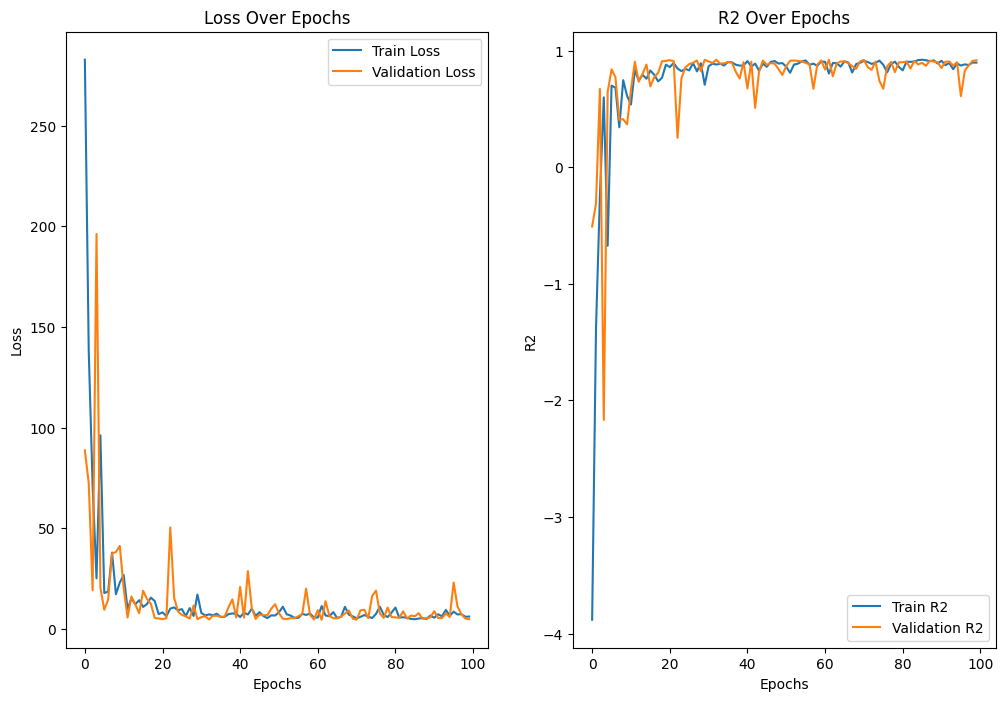

In [18]:
# Plot those loss and r2 on 2x2 plot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_r2, label='Train R2')
plt.plot(val_r2, label='Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.title('R2 Over Epochs')
plt.show()
